In [ ]:
import time
from torchvision import transforms, datasets
import torch
from torch.utils.data import Subset
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.init as init
import random
from sklearn.metrics import precision_score, accuracy_score, f1_score
from torchvision.transforms import GaussianBlur
from torch.autograd import Variable
from torch.nn import LazyLinear

default_batch_size = 600

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,), (0.5,))])

transform_blur = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    GaussianBlur(kernel_size=9, sigma=(1.5, 5.0))
])

#how to get train and test data
train_data = datasets.FashionMNIST('path', download=True, train=True, transform=transform)
test_data = datasets.FashionMNIST('path', download=True, train=False, transform=transform)

#train_data with blur
train_data_noise = datasets.FashionMNIST('path', download=True, train=True, transform=transform_blur)
test_data_noise = datasets.FashionMNIST('path', download=True, train=False, transform=transform_blur)

# use only 10% of train data
train_indices = list(range(len(train_data)))
random.shuffle(train_indices)
train_indices_10_percent = train_indices[:len(train_indices)//10]

test_indices = list(range(len(test_data)))
random.shuffle(test_indices)
test_indices_10_percent = test_indices[:len(test_indices)//10]
# dont use subset for now
train_data_10_percent = Subset(train_data, train_indices_10_percent)
test_data_10_percent = Subset(test_data, test_indices_10_percent)

train_data_10_percent_noisy = Subset(train_data_noise, train_indices_10_percent)
test_data_10_percent_noisy = Subset(test_data_noise, test_indices_10_percent)

print('100%: ',len(train_data))
print('100%: ',len(test_data))
print('10%: ',len(train_data_10_percent))
print('10%: ',len(test_data_10_percent))
# print out rest of configuration


train_loader = torch.utils.data.DataLoader(train_data_10_percent, batch_size=default_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data_10_percent, batch_size=default_batch_size, shuffle=True)

train_loader_noisy = torch.utils.data.DataLoader(train_data_10_percent_noisy, batch_size=default_batch_size, shuffle=True)
test_loader_noisy = torch.utils.data.DataLoader(test_data_10_percent_noisy, batch_size=default_batch_size, shuffle=True)

#shoow first input shape
print(next(iter(train_loader))[0].shape)


def plot_loss(losses, title):
    train, test = losses
    plt.plot(train)
    plt.plot(test)
    plt.legend(['Train' ,'Test'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Batch')
    plt.ylim(0, 3)
    plt.show()

#every batch take batch loss
def train(model, criterion, data_loader, test_loader, epochs):
    # Reset model
    model.apply(init_normal)
    optimizer = optim.Adam(model.parameters(), weight_decay=1e-5, lr=0.001)
    torch.manual_seed(seed)

    start_timestamp = time.time()
    training_loss = []
    test_loss_list = []

    for epoch in range(epochs):
        running_loss = 0
        test_loss = 0

        # Testing phase
        model.eval()
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(test_loader):
                images = Variable(images.view(-1, 1, 28, 28))
                labels = Variable(labels)
                logits = model(images)
                loss_test = criterion(logits, labels)
                test_loss += loss_test.item()


        # Training phase
        model.train()
        for batch_idx, (images, labels) in enumerate(data_loader):
            images = Variable(images.view(-1, 1, 28, 28))
            labels = Variable(labels)
            logits = model(images)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        running_loss = running_loss/len(data_loader)
        test_loss = test_loss/len(test_loader)
        training_loss.append(running_loss)
        test_loss_list.append(test_loss)




        print(f"Epoch {epoch}/{epochs} - Total Train Loss: {running_loss:.4f}, Total Test Loss: {test_loss:.4f}")

    print(f"\nTraining Time (in seconds) = {(time.time()-start_timestamp):.2f}")
    return training_loss, test_loss_list


class CustomCNN(nn.Module):
    def __init__(self, num_channels, kernel_size, pool_size):
        super(CustomCNN, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, num_channels, kernel_size=kernel_size),
            nn.Dropout2d(),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=pool_size),
        )

        self.fc_block = nn.Sequential(
            nn.Flatten(),
            LazyLinear(120),
            nn.Dropout2d(),
            nn.ReLU(),
            LazyLinear(10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x



def init_normal(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.manual_seed(seed)
        if hasattr(m, 'weight'):
            nn.init.xavier_normal_(m.weight)
        if hasattr(m, 'bias'):
            nn.init.constant_(m.bias, 0)


# Define the loss
criterion = nn.CrossEntropyLoss();

epochs = 50

def evaluate_model(model, test_loader):
    model.eval()
    total = 0
    correct = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 1, 28, 28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    accuracy = correct / total
    precision = precision_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1 Score: {f1:.4f}')





100%|██████████| 26421880/26421880 [00:01<00:00, 17275222.21it/s]


Extracting path/FashionMNIST/raw/train-images-idx3-ubyte.gz to path/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270347.63it/s]


Extracting path/FashionMNIST/raw/train-labels-idx1-ubyte.gz to path/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4982763.65it/s]


Extracting path/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to path/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17260013.58it/s]


Extracting path/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to path/FashionMNIST/raw

100%:  60000
100%:  10000
10%:  6000
10%:  1000
torch.Size([600, 1, 28, 28])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


CustomCNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5408, out_features=120, bias=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)
Epoch 0/50 - Total Train Loss: 1.5273, Total Test Loss: 2.2980
Epoch 1/50 - Total Train Loss: 0.9254, Total Test Loss: 0.8112
Epoch 2/50 - Total Train Loss: 0.7702, Total Test Loss: 0.7009
Epoch 3/50 - Total Train Loss: 0.6825, Total Test Loss: 0.6057
Epoch 4/50 - Total Train Loss: 0.6254, Total Test Loss: 0.5405
Epoch 5/50 - Total Train Loss: 0.5840, Total Test Loss: 0.5149
Epoch 6/50 - Total Train Loss: 0.5504, Total Test Loss: 0.4953
Epoch 7/50 

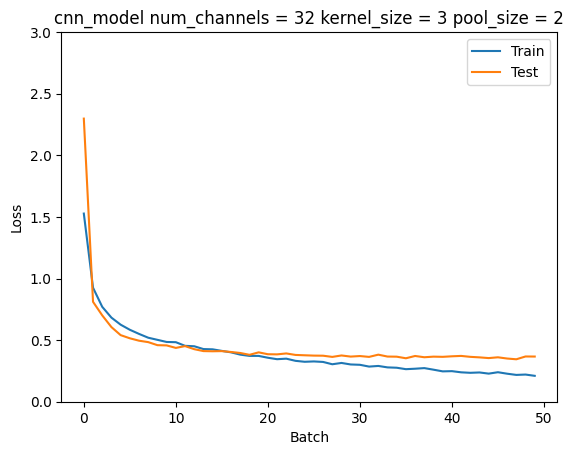

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


CustomCNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1352, out_features=120, bias=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)
Epoch 0/50 - Total Train Loss: 1.8813, Total Test Loss: 2.3363
Epoch 1/50 - Total Train Loss: 1.2594, Total Test Loss: 1.1996
Epoch 2/50 - Total Train Loss: 1.0229, Total Test Loss: 0.8441
Epoch 3/50 - Total Train Loss: 0.9243, Total Test Loss: 0.7097
Epoch 4/50 - Total Train Loss: 0.8288, Total Test Loss: 0.6481
Epoch 5/50 - Total Train Loss: 0.7913, Total Test Loss: 0.6104
Epoch 6/50 - Total Train Loss: 0.7477, Total Test Loss: 0.5840
Epoch 7/50 -

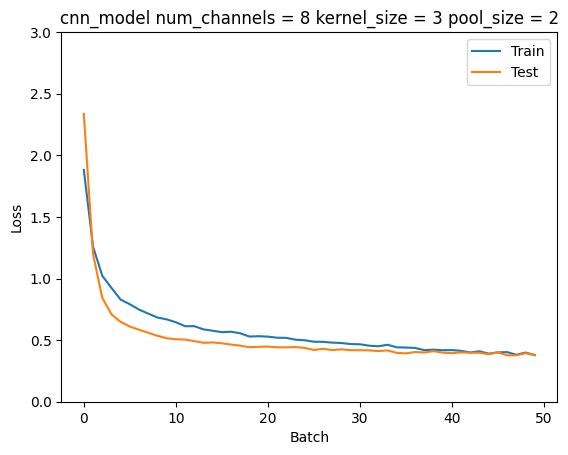

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


CustomCNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3200, out_features=120, bias=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)
Epoch 0/50 - Total Train Loss: 1.6402, Total Test Loss: 2.3510
Epoch 1/50 - Total Train Loss: 1.0216, Total Test Loss: 0.8818
Epoch 2/50 - Total Train Loss: 0.8175, Total Test Loss: 0.7571
Epoch 3/50 - Total Train Loss: 0.7434, Total Test Loss: 0.6449
Epoch 4/50 - Total Train Loss: 0.6645, Total Test Loss: 0.5895
Epoch 5/50 - Total Train Loss: 0.6283, Total Test Loss: 0.5571
Epoch 6/50 - Total Train Loss: 0.5965, Total Test Loss: 0.5518
Epoch 7/50 

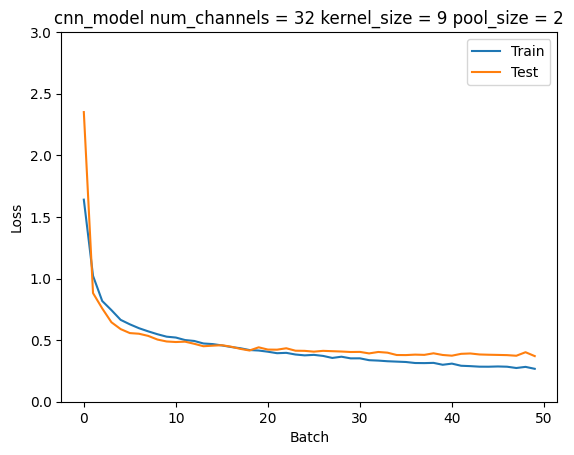

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


CustomCNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=120, bias=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)
Epoch 0/50 - Total Train Loss: 2.0037, Total Test Loss: 2.3614
Epoch 1/50 - Total Train Loss: 1.3684, Total Test Loss: 1.4216
Epoch 2/50 - Total Train Loss: 1.0704, Total Test Loss: 0.9416
Epoch 3/50 - Total Train Loss: 0.9277, Total Test Loss: 0.7784
Epoch 4/50 - Total Train Loss: 0.8182, Total Test Loss: 0.6989
Epoch 5/50 - Total Train Loss: 0.7543, Total Test Loss: 0.6487
Epoch 6/50 - Total Train Loss: 0.7142, Total Test Loss: 0.6115
Epoch 7/50 

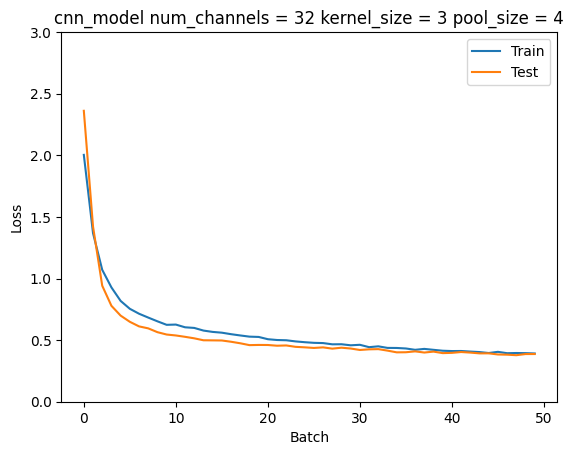

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


CustomCNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5408, out_features=120, bias=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)
Epoch 0/50 - Total Train Loss: 1.5109, Total Test Loss: 2.2896
Epoch 1/50 - Total Train Loss: 0.9430, Total Test Loss: 1.1976
Epoch 2/50 - Total Train Loss: 0.7627, Total Test Loss: 1.1913
Epoch 3/50 - Total Train Loss: 0.6848, Total Test Loss: 1.1180
Epoch 4/50 - Total Train Loss: 0.6187, Total Test Loss: 1.1340
Epoch 5/50 - Total Train Loss: 0.5965, Total Test Loss: 1.1256
Epoch 6/50 - Total Train Loss: 0.5493, Total Test Loss: 1.1151
Epoch 7/50 

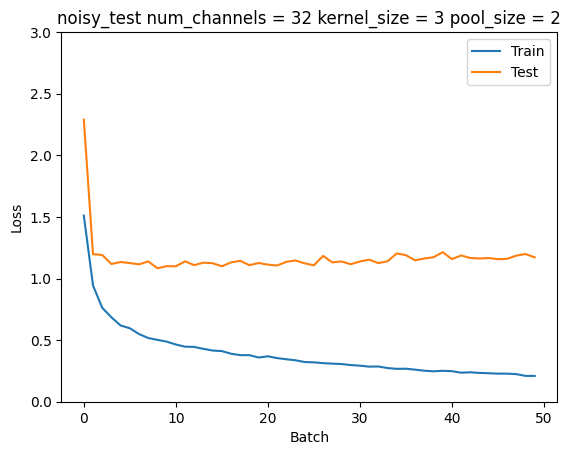

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


CustomCNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5408, out_features=120, bias=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)
Epoch 0/50 - Total Train Loss: 1.6608, Total Test Loss: 2.2980
Epoch 1/50 - Total Train Loss: 1.1600, Total Test Loss: 1.0969
Epoch 2/50 - Total Train Loss: 1.0105, Total Test Loss: 0.9520
Epoch 3/50 - Total Train Loss: 0.9137, Total Test Loss: 0.8776
Epoch 4/50 - Total Train Loss: 0.8690, Total Test Loss: 0.8436
Epoch 5/50 - Total Train Loss: 0.8280, Total Test Loss: 0.8321
Epoch 6/50 - Total Train Loss: 0.8123, Total Test Loss: 0.8031
Epoch 7/50 

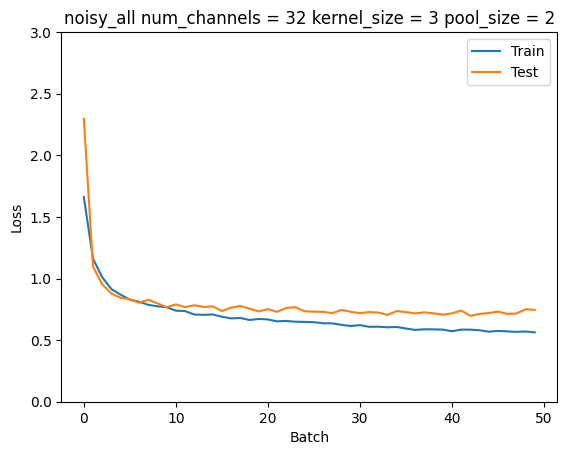

In [ ]:
num_channels = 32  # You can adjust this value
kernel_size = 3    # You can adjust this value
pool_size = 2      # You can adjust this value
#pass a dummy tensor to the model
#Each value is the darkness of the pixel (1 to 255)
dummy_tensor = torch.rand(1, 1, 28, 28)



cnn_model = CustomCNN(num_channels, kernel_size, pool_size)
cnn_model(dummy_tensor)

cnn_model.apply(init_normal)

print(cnn_model)

# train model
cnn_losses = train(
    cnn_model,
    criterion,
    train_loader,
    test_loader,
    epochs=epochs)

evaluate_model(cnn_model, test_loader)
plot_loss(cnn_losses, f'cnn_model num_channels = {num_channels} kernel_size = {kernel_size} pool_size = {pool_size}')

#try changinf channel size
num_channels = 8  # You can adjust this value
kernel_size = 3    # You can adjust this value
pool_size = 2      # You can adjust this value

cnn_model = CustomCNN(num_channels, kernel_size, pool_size)
cnn_model(dummy_tensor)
cnn_model.apply(init_normal)

print(cnn_model)

# train model
cnn_losses = train(
    cnn_model,
    criterion,
    train_loader,
    test_loader,
    epochs=epochs)

evaluate_model(cnn_model, test_loader)
plot_loss(cnn_losses,  f'cnn_model num_channels = {num_channels} kernel_size = {kernel_size} pool_size = {pool_size}')

#change filter size

num_channels = 32  # You can adjust this value
kernel_size = 9   # You can adjust this value
pool_size = 2      # You can adjust this value

cnn_model = CustomCNN(num_channels, kernel_size, pool_size)
cnn_model(dummy_tensor)
cnn_model.apply(init_normal)

print(cnn_model)

# train model
cnn_losses = train(
    cnn_model,
    criterion,
    train_loader,
    test_loader,
    epochs=epochs)

evaluate_model(cnn_model, test_loader)
plot_loss(cnn_losses,  f'cnn_model num_channels = {num_channels} kernel_size = {kernel_size} pool_size = {pool_size}')

# change pool size

num_channels = 32  # You can adjust this value
kernel_size = 3    # You can adjust this value
pool_size = 4      # You can adjust this value

cnn_model = CustomCNN(num_channels, kernel_size, pool_size)
cnn_model(dummy_tensor)
cnn_model.apply(init_normal)

print(cnn_model)

# train model
cnn_losses = train(
    cnn_model,
    criterion,
    train_loader,
    test_loader,
    epochs=epochs)

evaluate_model(cnn_model, test_loader)

plot_loss(cnn_losses,  f'cnn_model num_channels = {num_channels} kernel_size = {kernel_size} pool_size = {pool_size}')

num_channels = 32  # You can adjust this value
kernel_size = 3    # You can adjust this value
pool_size = 2      # You can adjust this value

cnn_model = CustomCNN(num_channels, kernel_size, pool_size)
cnn_model(dummy_tensor)
cnn_model.apply(init_normal)

print(cnn_model)

# train model
cnn_losses = train(
    cnn_model,
    criterion,
    train_loader,
    test_loader_noisy,
    epochs=epochs)

evaluate_model(cnn_model, test_loader_noisy)

plot_loss(cnn_losses,  f'noisy_test num_channels = {num_channels} kernel_size = {kernel_size} pool_size = {pool_size}')


# change data train loader to noisy

num_channels = 32  # You can adjust this value
kernel_size = 3    # You can adjust this value
pool_size = 2      # You can adjust this value

cnn_model = CustomCNN(num_channels, kernel_size, pool_size)
cnn_model(dummy_tensor)
cnn_model.apply(init_normal)

print(cnn_model)

# train model
cnn_losses = train(
    cnn_model,
    criterion,
    train_loader_noisy,
    test_loader,
    epochs=epochs)

evaluate_model(cnn_model, test_loader)

plot_loss(cnn_losses,  f'noisy_all num_channels = {num_channels} kernel_size = {kernel_size} pool_size = {pool_size}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


CustomCNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=120, bias=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)
Epoch 0/50 - Total Train Loss: 1.6283, Total Test Loss: 2.3210
Epoch 1/50 - Total Train Loss: 1.0406, Total Test Loss: 0.8983
Epoch 2/50 - Total Train Loss: 0.8685, Total Test Loss: 0.7749
Epoch 3/50 - Total Train Loss: 0.7816, Total Test Loss: 0.6885
Epoch 4/50 - Total Train Loss: 0.7161, Total Test Loss: 0.6129
Epoch 5/50 - Total Train Loss: 0.6771, Total Test Loss: 0.5833
Epoch 6/50 - Total Train Loss: 0.6422, Total Test Loss: 0.5714
Epoch 7/50 

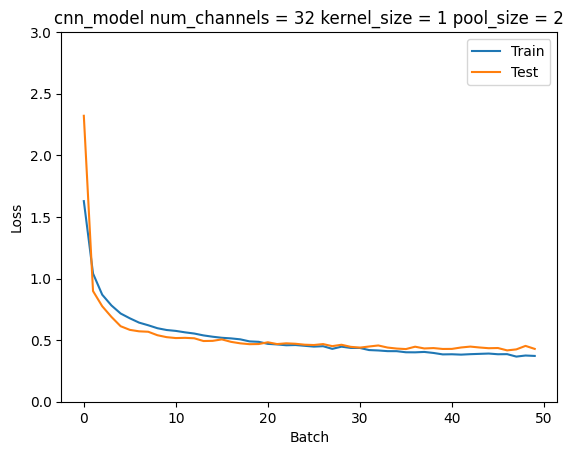

In [ ]:
num_channels = 32  # You can adjust this value
kernel_size = 1   # You can adjust this value
pool_size = 2      # You can adjust this value

cnn_model = CustomCNN(num_channels, kernel_size, pool_size)
cnn_model(dummy_tensor)
cnn_model.apply(init_normal)

print(cnn_model)

# train model
cnn_losses = train(
    cnn_model,
    criterion,
    train_loader,
    test_loader,
    epochs=epochs)

evaluate_model(cnn_model, test_loader)
plot_loss(cnn_losses,  f'cnn_model num_channels = {num_channels} kernel_size = {kernel_size} pool_size = {pool_size}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


CustomCNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=21632, out_features=120, bias=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)
Epoch 0/50 - Total Train Loss: 1.4393, Total Test Loss: 2.3163
Epoch 1/50 - Total Train Loss: 0.8781, Total Test Loss: 0.7865
Epoch 2/50 - Total Train Loss: 0.7324, Total Test Loss: 0.6666
Epoch 3/50 - Total Train Loss: 0.6435, Total Test Loss: 0.5814
Epoch 4/50 - Total Train Loss: 0.5832, Total Test Loss: 0.5282
Epoch 5/50 - Total Train Loss: 0.5407, Total Test Loss: 0.4982
Epoch 6/50 - Total Train Loss: 0.4948, Total Test Loss: 0.4840
Epoch 7/50

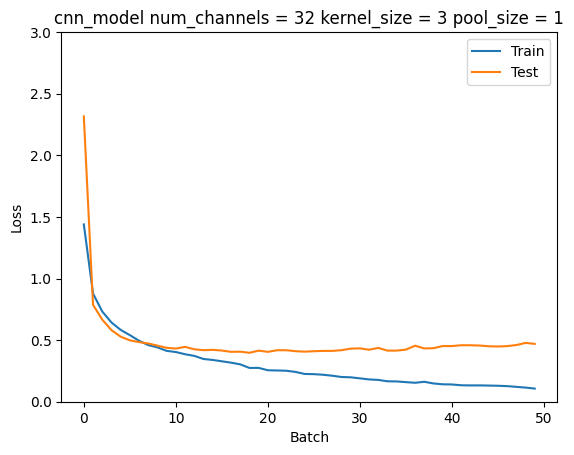

In [ ]:
num_channels = 32  # You can adjust this value
kernel_size = 3   # You can adjust this value
pool_size = 1      # You can adjust this value

cnn_model = CustomCNN(num_channels, kernel_size, pool_size)
cnn_model(dummy_tensor)
cnn_model.apply(init_normal)

print(cnn_model)

# train model
cnn_losses = train(
    cnn_model,
    criterion,
    train_loader,
    test_loader,
    epochs=epochs)

evaluate_model(cnn_model, test_loader)
plot_loss(cnn_losses,  f'cnn_model num_channels = {num_channels} kernel_size = {kernel_size} pool_size = {pool_size}')


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


CustomCNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10816, out_features=120, bias=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)
Epoch 0/50 - Total Train Loss: 1.4246, Total Test Loss: 2.3033
Epoch 1/50 - Total Train Loss: 0.8303, Total Test Loss: 0.7430
Epoch 2/50 - Total Train Loss: 0.6997, Total Test Loss: 0.6333
Epoch 3/50 - Total Train Loss: 0.6224, Total Test Loss: 0.5555
Epoch 4/50 - Total Train Loss: 0.5669, Total Test Loss: 0.5035
Epoch 5/50 - Total Train Loss: 0.5194, Total Test Loss: 0.4733
Epoch 6/50 - Total Train Loss: 0.4973, Total Test Loss: 0.4603
Epoch 7/50

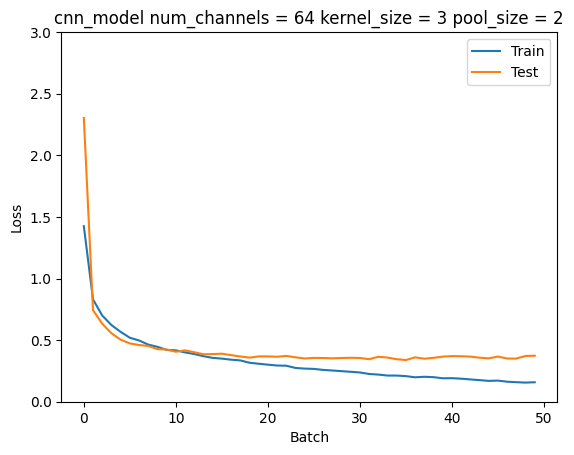

In [ ]:
num_channels = 64  # You can adjust this value
kernel_size = 3   # You can adjust this value
pool_size = 2      # You can adjust this value

cnn_model = CustomCNN(num_channels, kernel_size, pool_size)
dummy_tensor = torch.rand(1, 1, 28, 28)
cnn_model(dummy_tensor)
cnn_model.apply(init_normal)

print(cnn_model)

# train model
cnn_losses = train(
    cnn_model,
    criterion,
    train_loader,
    test_loader,
    epochs=epochs)

evaluate_model(cnn_model, test_loader)
plot_loss(cnn_losses,  f'cnn_model num_channels = {num_channels} kernel_size = {kernel_size} pool_size = {pool_size}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


CustomCNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): Dropout2d(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1352, out_features=120, bias=True)
    (2): Dropout2d(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)
Epoch 0/100 - Total Train Loss: 1.8813, Total Test Loss: 2.3363
Epoch 1/100 - Total Train Loss: 1.2594, Total Test Loss: 1.1996
Epoch 2/100 - Total Train Loss: 1.0229, Total Test Loss: 0.8441
Epoch 3/100 - Total Train Loss: 0.9243, Total Test Loss: 0.7097
Epoch 4/100 - Total Train Loss: 0.8288, Total Test Loss: 0.6481
Epoch 5/100 - Total Train Loss: 0.7913, Total Test Loss: 0.6104
Epoch 6/100 - Total Train Loss: 0.7477, Total Test Loss: 0.5840
Epoch

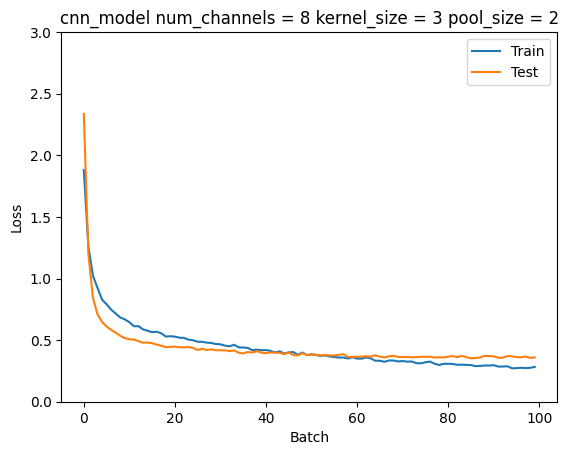

In [ ]:
num_channels = 8  # You can adjust this value
kernel_size = 3    # You can adjust this value
pool_size = 2      # You can adjust this value
epochs = 100

cnn_model = CustomCNN(num_channels, kernel_size, pool_size)
cnn_model(dummy_tensor)
cnn_model.apply(init_normal)

print(cnn_model)

# train model
cnn_losses = train(
    cnn_model,
    criterion,
    train_loader,
    test_loader,
    epochs=epochs)

evaluate_model(cnn_model, test_loader)
plot_loss(cnn_losses,  f'cnn_model num_channels = {num_channels} kernel_size = {kernel_size} pool_size = {pool_size}')